This is to explore the behavior of Thompson Sampling when one tries to change the risk-awareness


In [2]:
%load_ext autoreload
%autoreload 2

In [65]:
from adaptive_nof1 import SeriesOfSimulationsRunner
from adaptive_nof1.policies import *
from adaptive_nof1.metrics import SimpleRegret
from adaptive_nof1.metrics.simple_regret import MaximizingSimpleRegret
from adaptive_nof1 import SeriesOfSimulationsData
from adaptive_nof1.inference import GaussianAverageTreatmentEffect
from adaptive_nof1.inference.bayes import BayesianModel
import bambi
import pymc
import logging
import pandas
import arviz
import seaborn
import matplotlib.pyplot as plt

In [33]:
import numpy
from adaptive_nof1.models import Model
from adaptive_nof1.basic_types import Outcome

N_TREATMENTS = 2

N_PATIENTS = 100
N_DECISION_POINTS = 10


class RiskModel(Model):
    def __init__(
        self,
        patient_id,
        variance_treatment_1,
        variance_treatment_2,
    ):
        self.patient_id = patient_id
        self.rng = numpy.random.default_rng(patient_id)
        self.variance_treatment_1 = variance_treatment_1
        self.variance_treatment_2 = variance_treatment_2
        self.treatment_effect = 0

    def generate_context(self, history):
        return {"patient_id": self.patient_id}

    def observe_outcome(self, action, context):
        baseline = 0
        treatment = action["treatment"]
        if treatment == 0:
            return {
                "outcome": self.rng.normal(
                    self.treatment_effect, self.variance_treatment_1
                )
            }
        if treatment == 1:
            return {
                "outcome": self.rng.normal(
                    self.treatment_effect, self.variance_treatment_2
                )
            }

    def __str__(self):
        return f"GenericVsSpecializedModel[{self.treatment_effect, self.variance_treatment_1, self.variance_treatment_2}]"


data_generating_model = lambda patient_id: RiskModel(
    patient_id,
    1,
    10,
)


class RiskBayes(BayesianModel):
    def __str__(self):
        return "RiskBayes"

    def update_posterior(self, history, number_of_treatments):
        # Simple model with baseline + treatment effects + noise
        df = history.to_df()
        self.model = pymc.Model()
        with self.model:
            logger = logging.getLogger("pymc")
            logger.disabled = False

            patient_id = pymc.MutableData("patient_id", df["patient_id"], dims="obs_id")
            treatment = pymc.MutableData(
                "treatment", df[self.treatment_name], dims="obs_id"
            )
            # random_noise_variance = pymc.Exponential("random_noise_variance", lam=1)
            # treatment_variance = pymc.Exponential("treatment_variance", lam=1)

            treatment_hyperprior = pymc.Normal(
                "treatment_hyperprior",
                mu=0,
                sigma=[1, 10],
                shape=N_TREATMENTS,
                dims="treatment_id",
            )

            mu = 0
            if len(df) > 0:
                mu = treatment_hyperprior[treatment]

            outcome = pymc.Normal(
                "outcome",
                mu=mu,
                observed=df["outcome"],
                sigma=1,
                dims="obs_id",
            )
            self.trace = pymc.sample(2000, progressbar=False)

    def approximate_max_probabilities(self, number_of_treatments, context):
        assert (
            self.trace is not None
        ), "You called `approximate_max_probabilites` without updating the posterior"

        df = pandas.DataFrame([context] * number_of_treatments)
        df[self.treatment_name] = range(number_of_treatments)
        df["patient_id"] = context["patient_id"]

        with self.model:
            pymc.set_data(
                {
                    "patient_id": df["patient_id"],
                    "treatment": df[self.treatment_name],
                }
            )
            pymc.sample_posterior_predictive(
                self.trace,
                var_names=["outcome"],
                extend_inferencedata=True,
            )

        max_indices = arviz.extract(self.trace.posterior_predictive).outcome.argmin(
            dim="obs_id"
        )
        bin_counts = numpy.bincount(max_indices, minlength=number_of_treatments)
        return bin_counts / numpy.sum(bin_counts)


# Can be used if you know the true parameters and just want to test out stuff
class FixedThompsonSampling(BayesianModel):
    def __init__(self, probabilities):
        self.probabilities = probabilities

    def __str__(self):
        return f"FixedRiskBayes{self.probabilities}"

    def update_posterior(self, history, number_of_treatments):
        pass

    def approximate_max_probabilities(self, number_of_treatments, context):
        return self.probabilities

# Different Probability Thompson Sampling Algorithms

In [43]:
fixed_schedule_runner = SeriesOfSimulationsRunner(
    model_from_patient_id=data_generating_model,
    n_patients=N_PATIENTS,
    policy=FixedPolicy(number_of_actions=N_TREATMENTS),
)

thompson_runner_risk_neutral = SeriesOfSimulationsRunner(
    model_from_patient_id=data_generating_model,
    n_patients=N_PATIENTS,
    policy=ThompsonSampling(
        inference_model=FixedThompsonSampling(numpy.array([0.5, 0.5])),
        number_of_actions=N_TREATMENTS,
    ),
)

thompson_runner_risk_averse = SeriesOfSimulationsRunner(
    model_from_patient_id=data_generating_model,
    n_patients=N_PATIENTS,
    policy=ThompsonSampling(
        inference_model=FixedThompsonSampling(numpy.array([0.8, 0.2])),
        number_of_actions=N_TREATMENTS,
    ),
)

thompson_runner_risk_seeking = SeriesOfSimulationsRunner(
    model_from_patient_id=data_generating_model,
    n_patients=N_PATIENTS,
    policy=ThompsonSampling(
        inference_model=FixedThompsonSampling(numpy.array([0.2, 0.8])),
        number_of_actions=N_TREATMENTS,
    ),
)

In [44]:
fixed_schedule_data = fixed_schedule_runner.simulate(N_DECISION_POINTS)
thompson_data_risk_neutral = thompson_runner_risk_neutral.simulate(N_DECISION_POINTS)
thompson_data_risk_averse = thompson_runner_risk_averse.simulate(N_DECISION_POINTS)
thompson_data_risk_seeking = thompson_runner_risk_seeking.simulate(N_DECISION_POINTS)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [45]:
fixed_schedule_data.plot_allocations()

:HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,treatment)

In [46]:
thompson_data_risk_averse.plot_allocations()

:HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,treatment)

<Axes: xlabel='t', ylabel='Regret'>

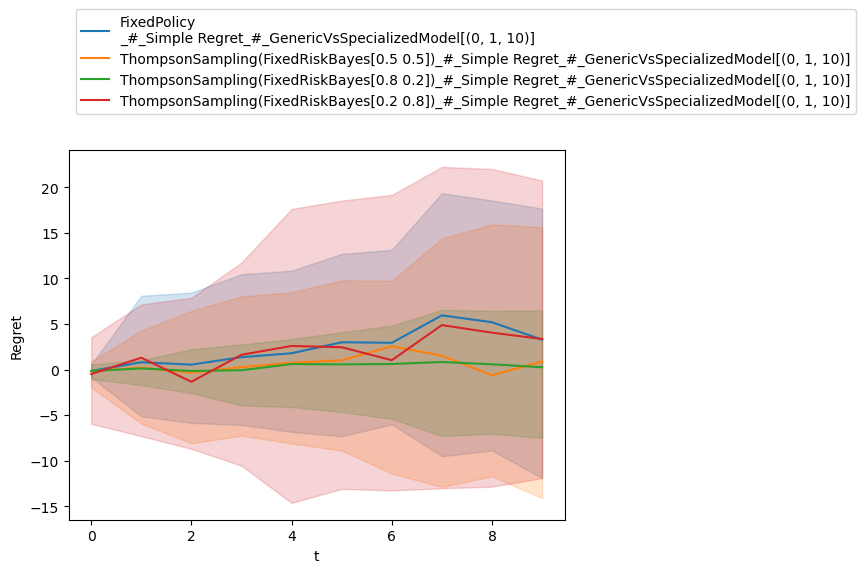

In [47]:
series = [
    fixed_schedule_data,
    thompson_data_risk_neutral,
    thompson_data_risk_averse,
    thompson_data_risk_seeking,
]

SeriesOfSimulationsData.plot_lines(
    series,
    [MaximizingSimpleRegret(outcome_name="outcome")],
)

# Regret Variance per Patient

{'policy': 'FixedPolicy\n', 'model': 'GenericVsSpecializedModel[(0, 1, 10)]'}


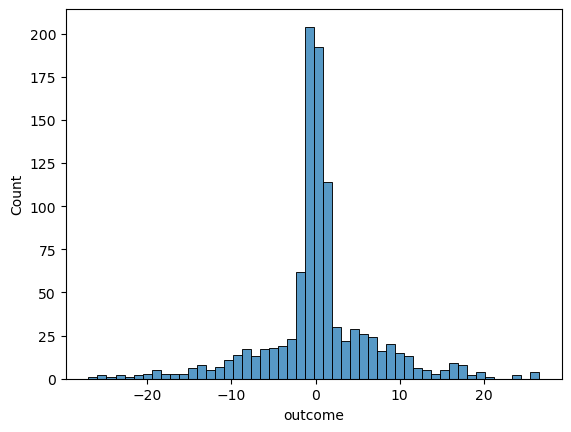

{'policy': 'ThompsonSampling(FixedRiskBayes[0.5 0.5])', 'model': 'GenericVsSpecializedModel[(0, 1, 10)]'}


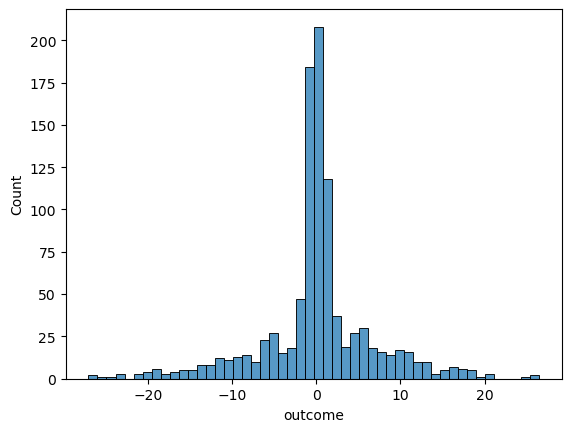

{'policy': 'ThompsonSampling(FixedRiskBayes[0.8 0.2])', 'model': 'GenericVsSpecializedModel[(0, 1, 10)]'}


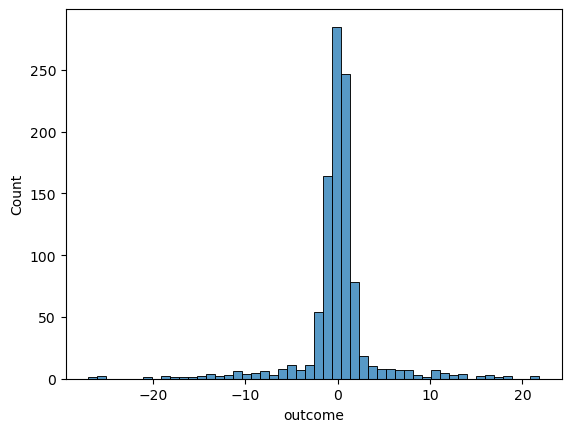

{'policy': 'ThompsonSampling(FixedRiskBayes[0.2 0.8])', 'model': 'GenericVsSpecializedModel[(0, 1, 10)]'}


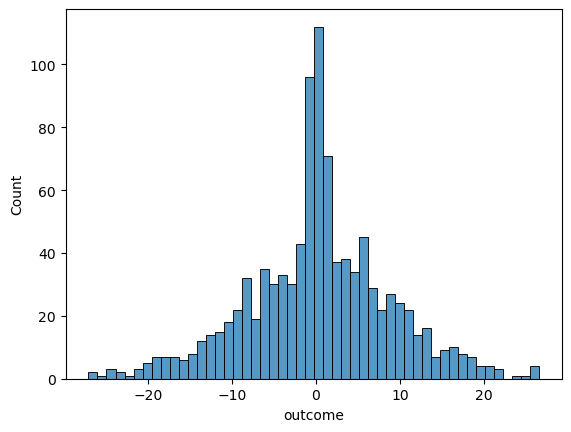

In [68]:
for data in series:
    df = data.pooled_histories().to_df()
    print(data.configuration)
    seaborn.histplot(data=df, x="outcome", bins=50)
    plt.show()